In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import clone_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = '/kaggle/input/chicken-disease-dataset/chicken_disease/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Global variables
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 30
NR_CLASS = 4
CHANNELS = 3

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    shear_range=0.1, 
    zoom_range=0.1,  
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 6508 images belonging to 4 classes.
Found 6508 images belonging to 4 classes.
Found 778 images belonging to 4 classes.
Found 781 images belonging to 4 classes.


# Simple Dense Layer

In [13]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        layers.Flatten(),
        
        layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        
        layers.Dense(NR_CLASS, activation='softmax')
    ])
    return model


model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  
        patience=3,
        min_lr=1e-6
    )
]


print("\nTraining with data augmentation:")
history_aug = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks
)

print("\nTraining without data augmentation:")
model_no_aug = create_model()
model_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_no_aug = model_no_aug.fit(
    train_generator_no_aug,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks
)


Training with data augmentation:
Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 100s 447ms/step - accuracy: 0.5031 - loss: 1.2853 - val_accuracy: 0.4936 - val_loss: 2.7273 - learning_rate: 1.0000e-04
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 69s 328ms/step - accuracy: 0.6141 - loss: 1.0002 - val_accuracy: 0.5887 - val_loss: 0.9477 - learning_rate: 1.0000e-04
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 69s 327ms/step - accuracy: 0.6290 - loss: 0.9229 - val_accuracy: 0.6054 - val_loss: 1.3556 - learning_rate: 1.0000e-04
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 69s 326ms/step - accuracy: 0.6544 - loss: 0.8928 - val_accuracy: 0.7172 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 321ms/step - accuracy: 0.6786 - loss: 0.8318 - val_accuracy: 0.6157 - val_loss: 0.8382 - learning_rate: 1.0000e-04
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 323ms/step - accuracy: 0.6711 - loss: 0.8345 - val_accuracy: 0.7159 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 7/30


In [14]:
print("\nEvaluating model WITH data augmentation:")
test_loss_aug, test_acc_aug = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc_aug:.4f}")

print("\nEvaluating model WITHOUT data augmentation:")
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc_no_aug:.4f}")


Evaluating model WITH data augmentation:
Test Accuracy: 0.7081

Evaluating model WITHOUT data augmentation:
Test Accuracy: 0.7734


# CNN + DATA Augmentation + Callbacks

### CNN from scratch

In [15]:
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='InputLayer'),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv1'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv2'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv3'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(units=128, activation='relu', name='dense1'),
    layers.Dense(units=64, activation='relu', name='dense2'),
    
    layers.Dense(NR_CLASS, activation='softmax')
])

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_scratch_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stop, reduce_lr]


history = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6097 - loss: 1.0495
Epoch 1: val_loss improved from inf to 0.49072, saving model to /kaggle/working/best_scratch_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 79s 349ms/step - accuracy: 0.6107 - loss: 1.0472 - val_accuracy: 0.8303 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 2/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7876 - loss: 0.5986
Epoch 2: val_loss improved from 0.49072 to 0.43127, saving model to /kaggle/working/best_scratch_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 69s 328ms/step - accuracy: 0.7875 - loss: 0.5987 - val_accuracy: 0.8496 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8108 - loss: 0.5142
Epoch 3: val_loss improved from 0.43127 to 0.34825, saving model to /kaggle/working/best_scratch_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 69s 328ms/step - accuracy: 0.8108 - loss: 0.5141 - val_accuracy: 0.8895 - val_loss: 0.3483 - lea

In [18]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Test accuracy: 0.9641, Test loss: 0.1358


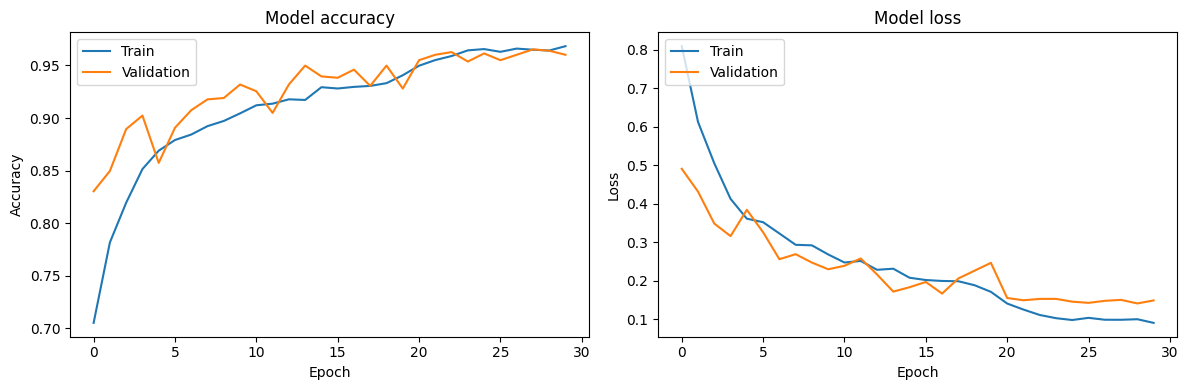

In [19]:
def display_results(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

display_results(history)

### Adjustments to the baseline CNN

In [20]:
model_plus = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NR_CLASS, activation='softmax')
])

In [21]:
model_plus.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_adjusted.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stop, reduce_lr]


history_adj = model_plus.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6572 - loss: 2.1444
Epoch 1: val_loss improved from inf to 13.17268, saving model to /kaggle/working/best_model_adjusted.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 96s 392ms/step - accuracy: 0.6575 - loss: 2.1437 - val_accuracy: 0.3085 - val_loss: 13.1727 - learning_rate: 0.0010
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7377 - loss: 1.9433
Epoch 2: val_loss improved from 13.17268 to 2.13843, saving model to /kaggle/working/best_model_adjusted.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 336ms/step - accuracy: 0.7378 - loss: 1.9428 - val_accuracy: 0.6337 - val_loss: 2.1384 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8101 - loss: 1.3833
Epoch 3: val_loss improved from 2.13843 to 1.18272, saving model to /kaggle/working/best_model_adjusted.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 335ms/step - accuracy: 0.8102 - loss: 1.3828 - val_accuracy: 0.8085 - val_loss: 1.1827

In [23]:
test_loss, test_acc = model_plus.evaluate(test_generator, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Test accuracy: 0.9629, Test loss: 0.2707


Test samples: 781
Class counts: [248 241  29 263]


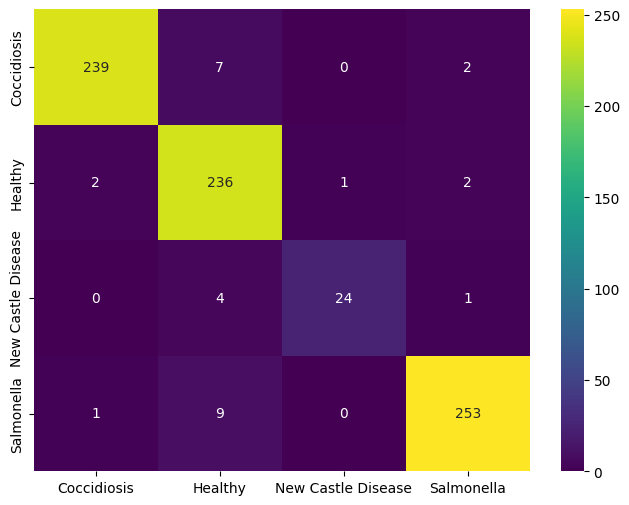


Classification Report:

                    precision    recall  f1-score   support

       Coccidiosis       0.99      0.96      0.98       248
           Healthy       0.92      0.98      0.95       241
New Castle Disease       0.96      0.83      0.89        29
        Salmonella       0.98      0.96      0.97       263

          accuracy                           0.96       781
         macro avg       0.96      0.93      0.95       781
      weighted avg       0.96      0.96      0.96       781



In [25]:
class_names = list(train_generator.class_indices.keys())

print(f"Test samples: {test_generator.samples}")
print(f"Class counts: {np.bincount(test_generator.classes)}")


test_generator.reset()
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = model_plus.predict(test_generator, steps=steps, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_generator.classes, y_pred_classes), 
            annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_names))

# Class Imbalance

In [26]:
model_architecture = clone_model(model_plus)
model_architecture.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,981,220 (99.11 MB)

 Trainable params: 25,979,812 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [27]:
model_architecture.load_weights('/kaggle/working/best_model_adjusted.keras')

model_architecture.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)
print("-------------------------------------------------------------------")

checkpoint = ModelCheckpoint(
    '/kaggle/working/model_with_class_weights.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stop, reduce_lr]

history_weighted = model_architecture.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Class weights: {0: 0.8217171717171717, 1: 0.8460738429537181, 2: 3.221782178217822, 3: 0.7747619047619048}
-------------------------------------------------------------------
Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8295 - loss: 1.2078
Epoch 1: val_loss improved from inf to 1.45450, saving model to /kaggle/working/model_with_class_weights.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 91s 390ms/step - accuracy: 0.8296 - loss: 1.2081 - val_accuracy: 0.8483 - val_loss: 1.4545 - learning_rate: 0.0010
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8608 - loss: 1.2119
Epoch 2: val_loss improved from 1.45450 to 1.35456, saving model to /kaggle/working/model_with_class_weights.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 339ms/step - accuracy: 0.8608 - loss: 1.2119 - val_accuracy: 0.8123 - val_loss: 1.3546 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8608 - loss: 1.2615
Epoch 3: val_loss improved from 1.35456 to 1.18

In [28]:
test_loss, test_acc = model_architecture.evaluate(test_generator, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Test accuracy: 0.9552, Test loss: 0.3049


# Tranfer Learning

In [29]:
base_model = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

base_model.trainable = True
for layer in base_model.layers[:8]: 
    layer.trainable = False

transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(NR_CLASS, activation='softmax')
])

initial_lr = 0.00005  
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

transfer_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    ModelCheckpoint(
        '/kaggle/working/best_vgg_enhanced.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  
        patience=3,
        min_lr=1e-7
    )
]

print("\nEnhanced Fine-Tuning Phase")
history_enhanced = transfer_model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=15,  
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=callbacks,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Enhanced Fine-Tuning Phase
Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 104s 420ms/step - accuracy: 0.5925 - loss: 1.6071 - precision: 0.6358 - recall: 0.5274 - val_accuracy: 0.7931 - val_loss: 1.0898 - val_precision: 0.8016 - val_recall: 0.7841 - learning_rate: 5.0000e-05
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 336ms/step - accuracy: 0.8355 - loss: 0.9524 - precision: 0.8643 - recall: 0.8106 - val_accuracy: 0.9087 - val_loss: 0.7336 - val_precision: 0.9384 - val_recall: 0.8805 - learning_rate: 5.0000e-05
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 337ms/step - accuracy: 0.8892 - loss: 0.7577 - precision: 0.9046 - recall: 0.8777 - val_accuracy: 0.9396 - val_loss: 0.6300 - val_precision: 0.9477 - val_recall: 0.9319 - learning_rate: 5.0000e-05
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 70s 334ms/step - accuracy: 0.9168 - loss: 0.6671 - precision: 0.9250 - recall: 0.9039 - val_accuracy: 0.9190 - val_loss: 0.6114 - val_precision: 0.9209 - val

In [30]:
results = transfer_model.evaluate(test_generator, verbose=0)
test_loss = results[0]
test_acc = results[1]
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.3966, Test Accuracy: 0.9770


Test samples: 781
Class counts: [248 241  29 263]


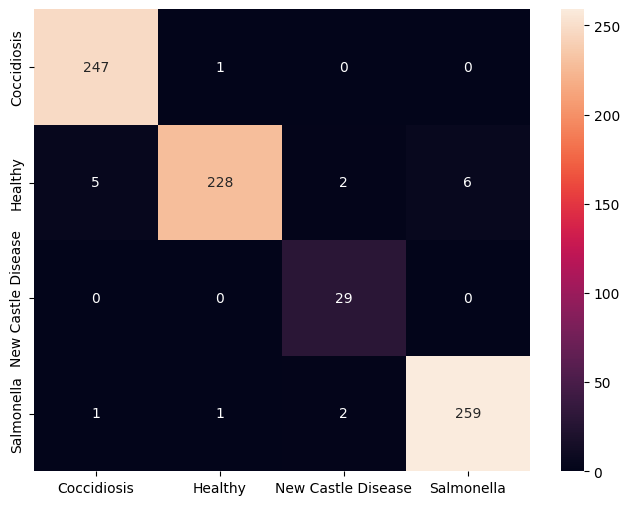


Classification Report:

                    precision    recall  f1-score   support

       Coccidiosis       0.98      1.00      0.99       248
           Healthy       0.99      0.95      0.97       241
New Castle Disease       0.88      1.00      0.94        29
        Salmonella       0.98      0.98      0.98       263

          accuracy                           0.98       781
         macro avg       0.96      0.98      0.97       781
      weighted avg       0.98      0.98      0.98       781



In [32]:
class_names = list(train_generator.class_indices.keys())

print(f"Test samples: {test_generator.samples}")
print(f"Class counts: {np.bincount(test_generator.classes)}")


test_generator.reset()
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = transfer_model.predict(test_generator, steps=steps, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_generator.classes, y_pred_classes), 
            annot=True, fmt='d', cmap='rocket',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_names))